# Generate telluric absorption spectra near 1430 nm for standard terrestrial atmospheric profiles 

Tom Schad | 6 March 2024

This notebook uses Py4CAfS to generate telluric absorption spectra near the Si X 1430 nm coronal line. 

The terrestrial atmospheric profile is selected from the standard available in the package. 

The altitude of DKIST is 3067 meters. 


In [72]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob
import sys
from py4cats import *
import py4cats 
print(py4cats.__file__)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'
plt.rcParams['font.sans-serif'] = "Comic Sans MS"
plt.rcParams['font.family'] = "serif"
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from scipy import ndimage

/home/tschad/dkist_telluric_atlas/py4cats/__init__.py


In [73]:
def vac2air(wave_vac):
    """ Converts wavelengths from vacuum to air-equivalent """
    wave_air = np.copy(wave_vac)
    ww  = (wave_vac >= 2000) 
    sigma2 = (1e4 / wave_vac[ww])**2 
    n = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wave_air[ww] = wave_vac[ww] / n
    return wave_air

In [74]:
def air2vac(wave_air): 
    """ Converts wavelengths from air-equivalent to vacuum
    Ciddor (1996) formula
    Adapted from airtovac.pro
    wave_air  :: angstroms 
    """
    wave_air = np.atleast_1d(wave_air)
    wave_vac = np.copy(wave_air)
    ww  = (wave_air >= 2000) 
    sigma2 = (1e4 / wave_air[ww])**2 
    n = 1. + 8.336624212083e-5 + 0.02408926869968 / (130.1065924522 - sigma2) + \
        0.0001599740894897 / (38.92568793293 - sigma2)
    wave_vac[ww] = wave_air[ww] * n
    return wave_vac
    

In [75]:
wvnm_min = 1430-2
wvnm_max = 1430+2 
wnMin,wnMax = 1e7/air2vac([wvnm_max,wvnm_min])
print('range of wavenumbers [cm^-1] ',wnMin,'  ',wnMax)

range of wavenumbers [cm^-1]  6983.2402234636875    7002.801120448179


## Load different terrestial atmospheres for comparison 

Here we load standard terrestrial atmosphere profiles to compare their structure and some select molecular concentrations

In [76]:
atmos = 'USstandard_main','subarcticWinter','subarcticSummer','midlatitudeWinter','midlatitudeSummer','tropical',

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels


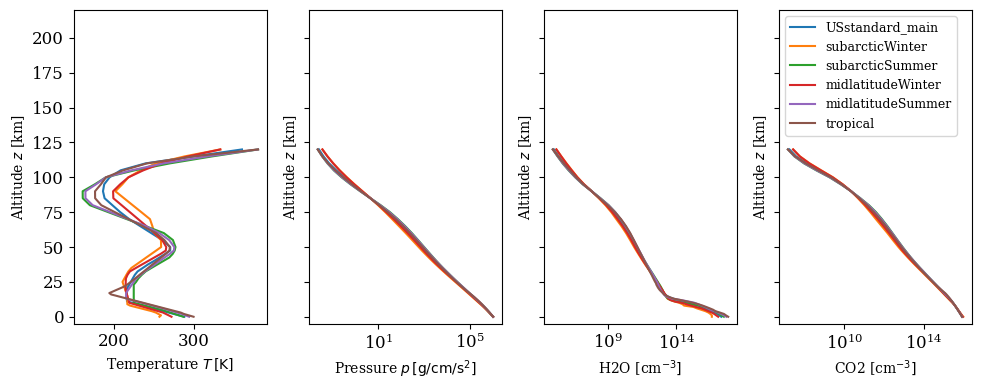

In [77]:
fig,ax = plt.subplots(1,4,figsize = (10,4),sharey=True)
ax = ax.flatten()

for n in range(len(atmos)): 
    
    atmDat = atmRead('./py4cats/data/atmos/50/' + atmos[n] + '.xy')
    
    ## plot z vs T
    plt.sca(ax[0])
    atmPlot(atmDat,label = atmos[n])
    
    ## plot z vs P
    plt.sca(ax[1])
    atmPlot(atmDat,'p',label = atmos[n])
    ax[1].set_xscale('log')

    ## plot h20 and c02 content 
    main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
    for mm in range(2): 
        plt.sca(ax[mm+2])
        atmPlot(atmDat,main_mol[mm],label = atmos[n])
        ax[mm+2].set_xscale('log')
        if mm==1: ax[mm+2].legend(loc = 'upper left',fontsize =9)
    ax[0].set_ylim(-5,220)

fig.tight_layout()

## Now do a finer comparison of 2 atmospheres -- midlatitudewinter and USstandard

In [78]:
atm_midLatWinter = atmRead('./py4cats/data/atmos/50/midlatitudeWinter.xy')
atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  

 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p, T, air   and 7 molecules on 50 levels


In [79]:
#REGRIDDING THE LOWER PORTION OF THE PROFILE FOR FINER SAMPLING 
znew = np.hstack((parseGridSpec('0[0.1]7'),atm_midLatWinter['z'][8:]/1e5))
print(znew.shape)
atm_midLatWinter = atmRegrid(atm_midLatWinter,znew*1e5)
atm_standard  = atmRegrid(atm_standard,znew*1e5)

(113,)
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)


In [80]:
print(' Height index,  z [km] ,  P (atm) ,  T (K)')
for n in range(10): 
    print('        ',n,'    ', np.round(atm_midLatWinter['z'][n]/1e5,2),'      ',np.round(atm_midLatWinter['p'][n]/1000.*100./101325.,2),'     ',atm_midLatWinter['T'][n])

 Height index,  z [km] ,  P (atm) ,  T (K)
         0      0.0        1.0       272.2
         1      0.1        0.99       271.84999999999997
         2      0.2        0.98       271.5
         3      0.3        0.97       271.15
         4      0.4        0.96       270.8
         5      0.5        0.94       270.45
         6      0.6        0.93       270.09999999999997
         7      0.7        0.92       269.75
         8      0.8        0.91       269.4
         9      0.9        0.9       269.05


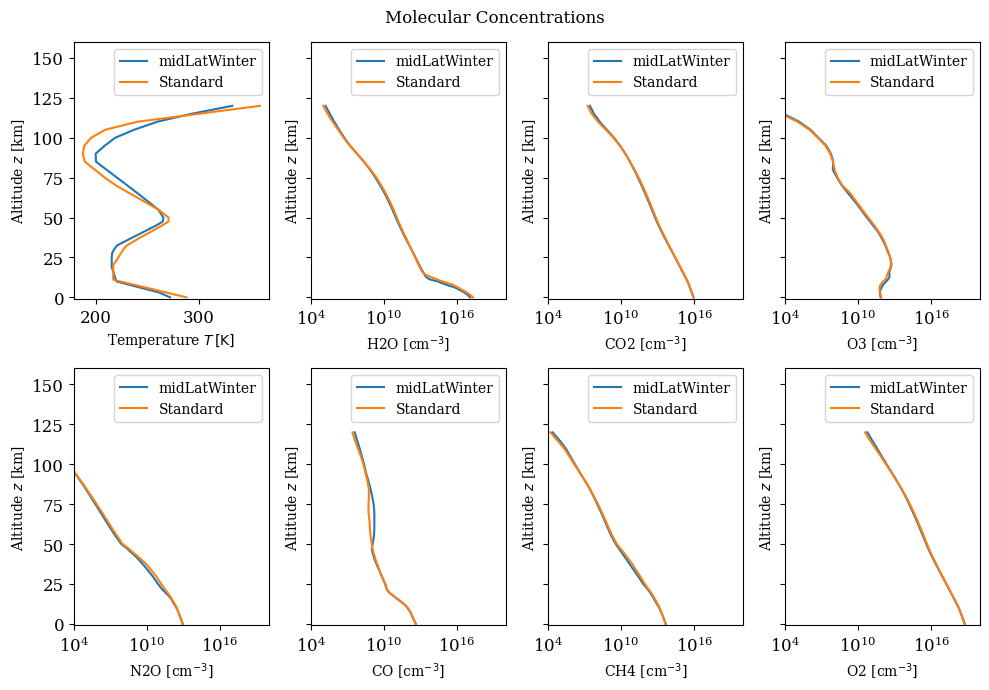

In [81]:
fig,ax = plt.subplots(2,4,figsize = (10,7),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
atmPlot(atm_midLatWinter,label = 'midLatWinter')
atmPlot(atm_standard,label = 'Standard')
ax[0].legend()

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    atmPlot(atm_midLatWinter,main_mol[n-1],label = 'midLatWinter')
    atmPlot(atm_standard,main_mol[n-1],label = 'Standard')
    ax[n].set_xscale('log')
    ax[n].legend(loc = 'upper right')
    
ax[0].set_ylim(-1,160)

for n in range(1,8): 
    ax[n].set_xlim(1e4,1e20)

fig.suptitle("Molecular Concentrations") 
fig.tight_layout()

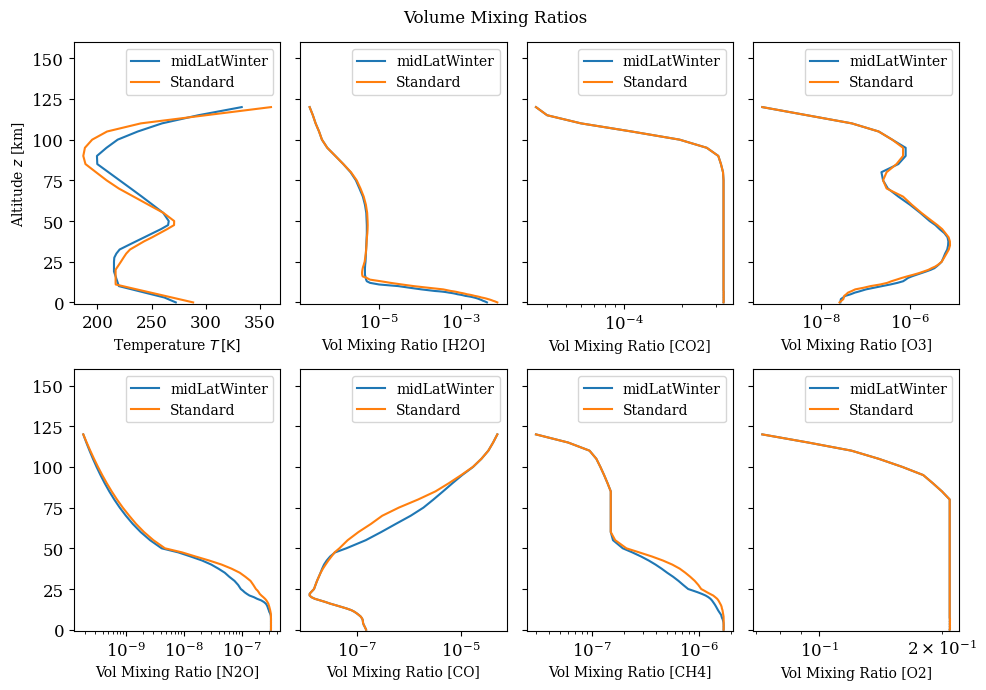

In [82]:
fig,ax = plt.subplots(2,4,figsize = (10,7),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
atmPlot(atm_midLatWinter,label = 'midLatWinter')
atmPlot(atm_standard,label = 'Standard')
ax[0].legend()

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    plt.plot(vmr(atm_midLatWinter,main_mol[n-1]),atm_midLatWinter['z']/1e5,label = 'midLatWinter')
    plt.plot(vmr(atm_standard,main_mol[n-1]),atm_standard['z']/1e5,label = 'Standard')
    plt.xscale('log')
    plt.xlabel('Vol Mixing Ratio ['+main_mol[n-1] + ']')
    ax[n].legend(loc = 'upper right')
    
ax[0].set_ylim(-1,160)
fig.suptitle("Volume Mixing Ratios") 
fig.tight_layout()

## Get vertical column densities [molec / cm**2 ] 

In [83]:
for mol in 'H2O','N2O','CO2',: 
    print('----- Molecule: ',mol)
    print(f"Vertical column density in midLatWinter (full atmosphere): {vcd(atm_midLatWinter,mol,zMin = 0.0)}") 
    print(f"Vertical column density in midLatWinter (above 3km): {vcd(atm_midLatWinter,mol,zMin = 3.0)}") 
    print(f"Vertical column density in US standard (full atmosphere): {vcd(atm_standard,mol,zMin = 0.0)}") 
    print(f"Vertical column density in US standard  (above 3km): {vcd(atm_standard,mol,zMin = 3.0)}") 

----- Molecule:  H2O
Vertical column density in midLatWinter (full atmosphere): 2.8906793192153e+22
Vertical column density in midLatWinter (above 3km): 6.689164304859454e+21
Vertical column density in US standard (full atmosphere): 4.808953629516041e+22
Vertical column density in US standard  (above 3km): 1.1474288295160398e+22
----- Molecule:  N2O
Vertical column density in midLatWinter (full atmosphere): 6.46984417129518e+18
Vertical column density in midLatWinter (above 3km): 4.265045201107645e+18
Vertical column density in US standard (full atmosphere): 6.62199191379642e+18
Vertical column density in US standard  (above 3km): 4.5015119137964196e+18
----- Molecule:  CO2
Vertical column density in midLatWinter (full atmosphere): 7.151195964449711e+21
Vertical column density in midLatWinter (above 3km): 4.877497026443813e+21
Vertical column density in US standard (full atmosphere): 7.118266103760752e+21
Vertical column density in US standard  (above 3km): 4.931521103760752e+21


In [84]:
print(' Column Mixing Ratios: ')
for mol in main_mol: 
    print(mol,': ',cmr(atm_standard,mol),' ',cmr(atm_midLatWinter,mol))

 Column Mixing Ratios: 
H2O :  0.0022305755912426202   0.0013347922335154915
CO2 :  0.0003301722546369477   0.0003302116831238814
O3 :  4.308899652075879e-07   4.7080394840993804e-07
N2O :  3.0715317023771747e-07   2.987497677274201e-07
CO :  1.1096299619118793e-07   1.1200916736041277e-07
CH4 :  1.6483812464617394e-06   1.5915415790250604e-06
O2 :  0.2091091150936424   0.20913409169086775


##  Calculate precipitable water
* mass density of water is ~ 0.9998 g/cm**3
* average molar mass of water is 18.01528 g/mol
* Na = 6.022e23

In [87]:
# V = rho * h * Na / M 
rho = 0.9998  # g/cm**3
Na = 6.022e23 # molec / mole 
M = 18.01528 # g / mole 
V = vcd(atm_midLatWinter,'H2O',zMin = 0.0)
print(V)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [midLatWinter]')
V = vcd(atm_standard,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [standard]')

2.8906793192153e+22
8.64942123693304  millimeters PWV [midLatWinter]
14.389235559291825  millimeters PWV [standard]


## Here we start to work with the HITRAN Database to calculate the telluric absorption spectra

### Load Line List

In [88]:
dictOfLineLists = higstract('./HITRAN_VIS_IR/65e912c9.par',(wnMin,wnMax),molecule = 'main')

# first line in spectral range at record number 1038726 found in 7037917.503953325 sec
 b' 61 6983.247100 7.526E-26 0.000E+00.04930.065  999.99000.62-.014000'
# last  line     accepted 
 b' 25 7002.783475 2.109E-30 5.674E-05.07350.099  125.90430.70-.007937'
# first line not accepted 
 b' 44 7002.803335 1.714E-29 6.470E-04.09310.120  585.01590.75-.005611'
 main gases only:  deleted  0  of  5  molecules in dict of linelists with originally 1926 lines

 1926 lines of  5  molecule(s) extracted from  ./HITRAN_VIS_IR/65e912c9.par
 returning a dictionary of lineArray's for  CH4 H2O N2O CO2 O3


In [89]:
for k in dictOfLineLists.keys(): 
    print(k,' ',dictOfLineLists[k]['v'].min(),dictOfLineLists[k]['v'].max(),len(dictOfLineLists[k]))
    wvair = vac2air((1e7/dictOfLineLists[k]['v'])*10)/10.
    strength = dictOfLineLists[k]['S']
    smax = np.flip(np.argsort(strength))
    for ll in range(3): 
        print(' --- ',ll,' ',dictOfLineLists[k]['v'][smax[ll]],wvair[smax[ll]],strength[smax[ll]])
    print(wvair[np.argmax(dictOfLineLists[k]['S'])])

CH4   6983.2471 7002.7829 553
 ---  0   6995.6376 1429.0715926814999 2.336e-23
 ---  1   6995.8148 1429.0353950582353 2.023e-23
 ---  2   6996.4571 1428.9042042559372 1.439e-23
1429.0715926814999
H2O   6983.297034 7002.75845 846
 ---  0   6987.144435 1430.808691328904 8.511e-22
 ---  1   6993.263186 1429.5568043242824 6.637e-22
 ---  2   7001.948706 1427.783517560561 5.526e-22
1430.808691328904
N2O   6983.545319 7002.230061 68
 ---  0   6991.824507 1429.8509587977492 2.259e-27
 ---  1   6992.847776 1429.6417272494014 2.253e-27
 ---  2   6990.785788 1430.063412110277 2.248e-27
1429.8509587977492
CO2   6983.599825 7002.783475 101
 ---  0   6983.896231 1431.4741601959654 5.87e-23
 ---  1   6984.699402 1431.3095546493794 5.597e-23
 ---  2   6985.428523 1431.1601580273805 5.214e-23
1431.4741601959654
O3   6983.7412 6996.6808 358
 ---  0   6995.4886 1429.1020311542027 2.343e-27
 ---  1   6996.297 1428.9369026832017 2.323e-27
 ---  2   6995.3608 1429.1281398168635 2.31e-27
1429.1020311542027


In [90]:
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=False)
plt.rcParams['font.sans-serif'] = "Comic Sans MS"
plt.rcParams['font.family'] = "serif"

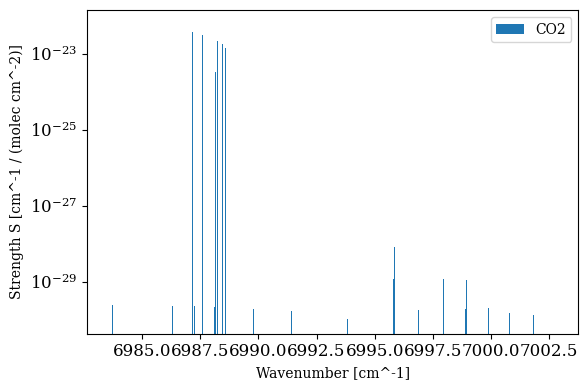

In [91]:
plt.figure(figsize = (6,4))
plt.bar(dictOfLineLists['CO2']['v'],dictOfLineLists['CO2']['S'],width = 0.01,label = 'CO2')
plt.yscale('log')
plt.legend()
plt.ylabel('Strength S [cm^-1 / (molec cm^-2)]')
plt.xlabel('Wavenumber [cm^-1]')
plt.tight_layout()

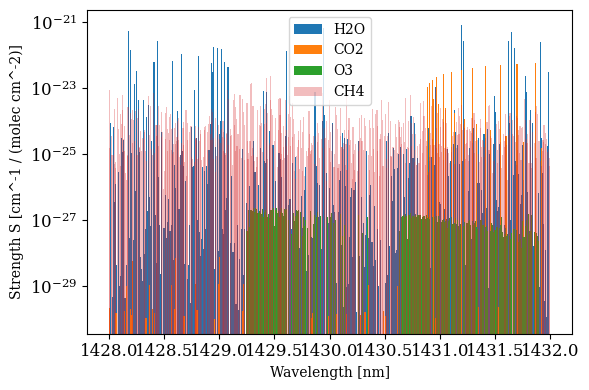

In [92]:
plt.figure(figsize = (6,4))
plt.bar(1e7/dictOfLineLists['H2O']['v'],dictOfLineLists['H2O']['S'],width = 0.01,label = 'H2O')
plt.bar(1e7/dictOfLineLists['CO2']['v'],dictOfLineLists['CO2']['S'],width = 0.01,label = 'CO2')
plt.bar(1e7/dictOfLineLists['O3']['v'],dictOfLineLists['O3']['S'],width = 0.01,label = 'O3')
plt.bar(1e7/dictOfLineLists['CH4']['v'],dictOfLineLists['CH4']['S'],width = 0.01,label = 'CH4',alpha =0.3)
#plt.bar(1e7/dictOfLineLists['NH3']['v'],dictOfLineLists['NH3']['S'],width = 0.01,label = 'NH3',alpha =1,color = 'black')
plt.yscale('log')
plt.legend()
plt.ylabel('Strength S [cm^-1 / (molec cm^-2)]')
plt.xlabel('Wavelength [nm]')
plt.tight_layout()

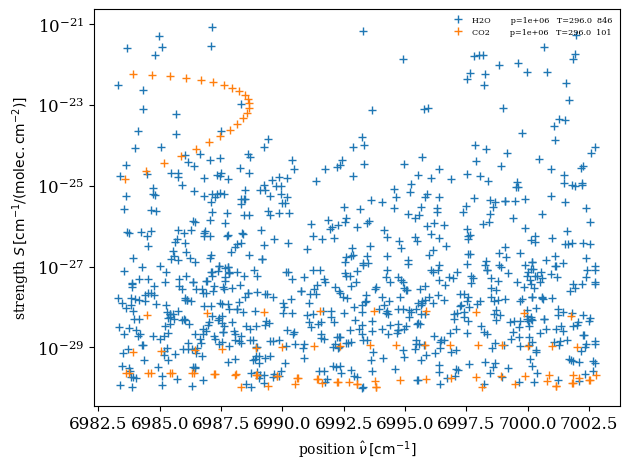

In [93]:
plt.figure()
atlas(dictOfLineLists['H2O'],yType = 'S')
atlas(dictOfLineLists['CO2'],yType = 'S')
plt.tight_layout()

In [94]:
atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  ## Ammonia wasn't really that important
znew = np.hstack((parseGridSpec('0[0.1]7'),atm_standard['z'][8:]/1e5))
atm_standard  = atmRegrid(atm_standard,znew*1e5)
atm_standard['CO2'] = atm_standard['CO2'] * 1.92
atm_standard['H2O'] = atm_standard['H2O'] * 0.48
atmDat = atm_standard

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)


## Get absorption cross sections

In [95]:
xssDict = lbl2xs(dictOfLineLists, atmDat['p'], atmDat['T'],(6979,7001))


 lbl2xs:  CH4       16.04amu 553 lines @ reference p [g/cm/s**2]  1.013e+06      T [K] 296.00  ---> 113 p,T pairs 
 cross section  CH4        553 lines      1013mb  288.2K        1857      0.17sec   162.66ns:  7.2262e-26 < xs < 1.74099e-22
 cross section  CH4        553 lines   1000.96mb  287.6K        1857      0.16sec   157.46ns:  7.14313e-26 < xs < 1.75208e-22
 cross section  CH4        553 lines   989.054mb  286.9K        1921      0.16sec   149.93ns:  7.06087e-26 < xs < 1.75588e-22
 cross section  CH4        553 lines   977.295mb  286.2K        1921      0.17sec   160.46ns:  6.97975e-26 < xs < 1.76647e-22
 cross section  CH4        553 lines   965.675mb  285.6K        1921      0.16sec   149.42ns:  6.89962e-26 < xs < 1.7771e-22
 cross section  CH4        553 lines   954.193mb  284.9K        1985      0.16sec   149.96ns:  6.82023e-26 < xs < 1.79667e-22
 cross section  CH4        553 lines   942.848mb  284.3K        1985      0.16sec   144.62ns:  6.74195e-26 < xs < 1.80855e-22
 cro

KeyboardInterrupt: 

## Absorption coefficients 

In [ ]:
absCoList = xs2ac(atmDat, xssDict) 

In [ ]:
absCoList[0].info()

In [ ]:
plt.figure(figsize = (8,4))
xUnit='1/cm'
plt.ylabel(r'absorption coefficient  $\alpha \rm\,[1/cm]$')
plt.xlabel(r'wavenumber $\nu \rm\,[cm^{-1}]$')
print(len(absCoList))
for n in range(0,len(absCoList),10): 
    plt.plot(absCoList[n].grid(),absCoList[n],label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')
plt.yscale('log')
plt.legend(ncol = 3)
plt.tight_layout()

## Optical Depth 

In [ ]:
## change the airmass for a slant geometry 
dodList = ac2dod(absCoList)
airmass = 1. ## 1/np.cos(zenith_angle)  == 2 @ 60 deg 
for n in range(len(dodList)): 
    dodList[n] = dodList[n]*airmass  ## airmass

In [ ]:
codList = dod2cod(dodList,True)  ## cummulative od 

In [ ]:
tod = dod2tod(dodList)  ## total od 

In [ ]:
print(len(codList))

In [ ]:
plt.figure(figsize = (8,3))

for n in 80,70,50,30,: 
    plt.plot(1e7/codList[n].grid(),np.exp(-codList[n]),lw = 0.8,label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')

plt.legend(loc = 'upper left',ncol = 4)
plt.ylim(0.,1.2)
plt.title('Transmission At Given Heights')
plt.tight_layout()

## Do the above for different molecules 

In [ ]:
atm_standard = atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  ## Ammonia wasn't really that important
znew = np.hstack((parseGridSpec('0[0.1]7'),atm_standard['z'][8:]/1e5))
atm_standard  = atmRegrid(atm_standard,znew*1e5)
atm_standard['CO2'] = atm_standard['CO2'] * 1.26  ## scaled to 11 Dec 2023 -  417 ppm 
atm_standard['H2O'] = atm_standard['H2O'] 
atmDat = atm_standard

In [ ]:
print(f"Vertical column density in US standard  (above 3km): {cmr(atm_standard,'H2O',zMin = .0)}") 
print(f"Vertical column density in US standard  (above 3km): {cmr(atm_standard,'CO2',zMin = .0)}") 

In [ ]:
V = vcd(atm_standard,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [standard]')

In [ ]:
main_mol

In [ ]:
absCoList = xs2ac(atmDat, xssDict)    ## recalculate for changes in molecular densities (xssDict ar the cross-sections for different p and T 
dodList = ac2dod(absCoList)
codList_all = dod2cod(dodList,True)  ## cummulative od 

In [ ]:
airmass = 1.5 ## 1/np.cos(np.deg2rad(45.)) ## 1/np.cos(zenith_angle)  == 2 @ 60 deg , 4 @ 75. 
print(airmass)
for n in range(len(dodList)): 
    dodList[n] = dodList[n]*airmass  ## airmass
codList_all_airmass = dod2cod(dodList,True)  ## cummulative od 

In [ ]:
cods = []
cods_mol = []
cods_airmass = []

airmass = 1.5 ## 1/np.cos(zenith_angle)  == 2 @ 60 deg , 4 @ 75. 
print(airmass)

for mol in main_mol: 
    print(mol)
    try: 
        absCoList = xs2ac(atmDat, xssDict[mol])    ## absorption coefficients for a single molecule 
        dodList = ac2dod(absCoList)
        codList = dod2cod(dodList,True)  ## cummulative od 
        cods_mol.append(mol)
        cods.append(codList)
        
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]*airmass  ## airmass
            
        codList = dod2cod(dodList,True)  ## cummulative od 
        cods_airmass.append(codList)

    except:
        print('failed')        

In [ ]:
len(cods),len(cods_airmass),len(cods_mol),cods_mol

In [ ]:
main_mol

## Load the Pseudo solar spectra

In [ ]:
# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
dc = np.loadtxt('../HITRAN_LineFits/solar_merged_20200720_600_33300_000.out',skiprows =3)  ## disk center -- 000
dcwv = vac2air(1e7/dc[:,0]*10)/10.
dcsp = dc[:,1]
ww = (dcwv >1427.5)*(dcwv < 1432)
dcwv = dcwv[ww][::-1]
dcsp = dcsp[ww][::-1]

# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
di = np.loadtxt('../HITRAN_LineFits/solar_merged_20200720_600_33300_100.out',skiprows =3)  ## disk integrated -- 100
diwv = vac2air(1e7/di[:,0]*10)/10.
disp = di[:,1]
ww = (diwv >1427.5)*(diwv < 1432)
diwv = diwv[ww][::-1]
disp = disp[ww][::-1]

## Read the FTS atlas for plotting

In [ ]:
from  scipy.io import readsav
idld = readsav('/home/tschad/cnSAT/combined_fts_atlases_2898A_54097A.sav')
ftswv    = np.copy(idld['lambda_angstrom']) /10.   ## nm 
ftsatm   = np.copy(idld['atm_absorption'])
ftscor   = np.copy(idld['corrected_flux'])
ftsobs   = np.copy(idld['observed_flux'])

In [ ]:
fdat = np.loadtxt('./KURUCZ/data/solar_flux/kurudz_full.dat',skiprows=11)  ## KURUCZ synthesis
fwv,fsp = fdat[:,0],fdat[:,1]
fwv = vac2air(fwv*10)/10.
fwv.shape

In [ ]:
wh = np.argmin(np.abs(atmDat['z'] - 3.e5))
#wh = np.argmin(np.abs(atmDat['z'] - 2.e5))  ## ~ kitt peak
print(wh)

In [ ]:
wv = vac2air(1e7/codList_all[0].grid()*10.)/10.

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [ ]:
len(atmDat['z'])

In [ ]:
plt.figure(figsize = (8,3))

for n in 110,80,70,50,30,: 
    plt.plot(vac2air(1e7/codList_all[n].grid()),np.exp(-codList_all[n]),lw = 0.8,label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')

plt.legend(loc = 'upper left',ncol = 4)
plt.ylim(0.,1.2)
plt.title('Transmission At Given Heights')
plt.tight_layout()


# ---  0   1432.4364550120997 1.071e-21
# ---  1   1431.1998403679772 8.511e-22
# ---  2   1429.9476130140886 6.637e-22
plt.plot([ 1429.9476130140886, 1429.9476130140886],[0,1],ls = 'dashed',color = 'black',lw = 2)
plt.plot([ 1431.1998403679772, 1431.1998403679772],[0,1],ls = 'dashed',color = 'black',lw = 2)
#plt.plot([ 1432.4364550120997, 1432.4364550120997 ],[0,1],ls = 'dashed',color = 'black',lw = 2)


In [ ]:
fig,ax = plt.subplots(5,1,figsize = (8,6),sharex=True)
ax = ax.flatten()

for n in range(len(cods)): 
    wv = vac2air(1e7/cods[n][wh].grid()*10.)/10.
    ax[n].plot(wv,np.exp(-cods[n][wh]),'b',lw = 0.85,label = cods_mol[n])
    ax[n].legend()
    ax[n].get_yaxis().get_major_formatter().set_useOffset(False)
fig.tight_layout()

k = 'H2O'
print(k,' ',dictOfLineLists[k]['v'].min(),dictOfLineLists[k]['v'].max(),len(dictOfLineLists[k]))
wvair = vac2air((1e7/dictOfLineLists[k]['v'])*10)/10.
strength = dictOfLineLists[k]['S']
smax = np.flip(np.argsort(strength))
for ll in range(15): 
    print(' --- ',ll,' ',wvair[smax[ll]],strength[smax[ll]])
    ax[0].plot(np.zeros(2) + wvair[smax[ll]], [0,1])

In [ ]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig,ax = plt.subplots(4,1,figsize = (8.,8.),sharex=True,sharey=False,height_ratios = [1,1,1,1.7])
ax = ax.flatten()

n = 0
wv = vac2air(1e7/codList_all[0].grid()*10.)/10.
ax[0].set_xlim(wv.min(),wv.max())

aa = 1.
th = 1.
for hh in 90,72,50,30,10,: 
    ax[n].plot(wv,np.exp(-codList_all[hh]),label = str(np.round(atmDat['z'][hh]/1e5,2)) + ' km',lw = th,color = 'blue',alpha = aa)
    th -= 0.2
    aa -= 0.05

#ax[n].plot(wv,np.exp(-codList_all[wh]),'b',label = '1 airmass',lw = 0.85)
#ax[n].plot(wv,np.exp(-codList_all_airmass[wh]),'k',lw = 0.85,linestyle = 'dashed',label = '1.5 airmass')
#ax[n].grid(lw = 0.5,linestyle = 'dotted',color = 'gray')
ax[n].set_title('(a) US Standard Atmosphere Model | Transmission Above Select Altitudes (7 main molecules)',fontsize = 12)
ax[n].set_yticks([0,0.25,0.5,0.75,1.0])
ax[n].set_yticklabels(['0',' ',' ',' ','1'])
ax[n].set_ylim(-0.1,1.04)

legend = ax[n].legend(ncol = 1,fontsize = 8,loc = 'lower left')
legend.get_frame().set_alpha(1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
    
labels = r'(b) US Standard Atmosphere Model | Transmission Above Select Altitudes  (H$_{2}$O absorption only)',r'(c) US Standard Atmosphere Model | Transmission Above Select Altitudes (CO$_{2}$ absorption only)',
for n in range(2):     
    wv = vac2air(1e7/cods[n][0].grid()*10.)/10.
    aa = 1.
    th = 0.9
    for hh in 90,72,50,30,10,: 
        if n == 0:         ax[n+1].plot(wv,np.exp(-cods[n][hh]),label = str(np.round(atmDat['z'][hh]/1e5,2)) + ' km',lw = th,color = 'red',alpha = aa)
        if n == 1:         
            if hh == 50: continue 
            if hh == 30: continue 
            ax[n+1].plot(wv,np.exp(-cods[n][hh]),label = str(np.round(atmDat['z'][hh]/1e5,2)) + ' km',lw = th,color = 'green',alpha = aa)
        th -= 0.15
        aa -= 0.05
    
    ax[n+1].set_title(labels[n],fontsize = 12)
    ax[n+1].set_ylim(-0.1,1.04)
    ax[n+1].set_yticks([0,0.25,0.5,0.75,1.0])
    ax[n+1].set_yticklabels(['0',' ',' ',' ','1'])
    legend = ax[n+1].legend(ncol = 1,fontsize = 8,loc = 'lower left')
    legend.get_frame().set_alpha(1)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')

ax[-1].set_xlabel('Wavelength (in air) [nm]',fontsize = 14)

n = 0
wv = vac2air(1e7/codList_all[wh].grid()*10.)/10.
## kurucz reference synthetic
ax[3].plot(dcwv,dcsp,label = 'Solar Pseudo-Transmittance Spectrum',lw = 0.75,color = 'red')
ax[3].plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max() ,label = 'Kurucz Synthetic Solar Spectrum',lw = 0.75,color = 'red',ls = 'dashed')
wwv = (ftswv>1426)*(ftswv<1434)
ax[3].set_title('(d) Modeled telluric transmission compared to solar spectrum and Si X coronal emission',fontsize=12)

## add coronal line 
ax[3].fill_between(wv,0.4*np.exp(-(wv-1430.078)**2/ (2*0.11**2)),label = 'Si X Coronal Line\n(no scattered light or absorption)',color = 'lightgreen',edgecolor = 'lightgreen',linewidth = 0)
ax[3].plot(wv,0.4*np.exp(-(wv-1430.078)**2/ (2*0.11**2)),color = 'black',ls = 'dashed',lw = 0.8)

sspec = np.interp(wv,fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max())
wvsh = 50./3e5 * 1430.1024
ax[3].plot(wv,np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh])),'b',label = 'Telluric Transmission for 1 airmass (7 main molecules)',lw = 0.9)

ax[1].annotate('', xy=( 1429.557, -0.03), xytext=( 1429.557, -0.1),fontsize = 8,verticalalignment = 'center',
            arrowprops=dict(facecolor='red',width = 0.5,headwidth = 3,headlength = 2,edgecolor = 'red'))
ax[1].annotate('', xy=( 1430.8094, -0.03), xytext=( 1430.8094, -0.1),fontsize = 8,verticalalignment = 'center',
            arrowprops=dict(facecolor='red',width = 0.5,headwidth = 3,headlength = 2,edgecolor = 'red'))

ax[3].plot(wv,(sspec + 0.4*np.exp(-(wv-1430.1024)**2/ (2*0.11**2))) * np.copy(np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh]))),ls = 'solid',
           color = 'green',lw = 1.5,label = 'Synthetic Si X Emission with -50, 0, +50 km/s Doppler shifts')  #  -50, 0, and +50 km/s Doppler shifts
ax[3].plot(wv,(sspec + 0.4*np.exp(-(wv-1430.1024-wvsh)**2/ (2*0.11**2))) * np.copy(np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh]))),ls = 'solid',color = 'green',lw = 1.)
ax[3].plot(wv,(sspec + 0.4*np.exp(-(wv-1430.1024+wvsh)**2/ (2*0.11**2))) * np.copy(np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh]))),ls = 'solid',color = 'green',lw = 1.)

ax[3].plot(wv,np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh])),'b',lw = 1.2)

legend = ax[3].legend(ncol=2,fontsize = 9,loc = 'upper left',frameon = False)
legend.get_frame().set_edgecolor('black')

ax[3].set_ylim(-0.1,2.)
ax[3].set_yticks([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75])
ax[3].set_yticklabels(['0',' ',' ',' ','1',' ',' ',' '])

for n in range(4): 
    for yy in 0,0.25,0.5,0.75,1,: 
        ax[n].plot(wv,wv*0+yy,ls = 'dotted',lw =0.5,color = 'gray')
    for xx in 1429,1429.5,1430.,1430.5,1431.,1431.5,1432.,:
        ax[n].plot([xx,xx],[0,1],ls = 'dotted',lw =0.5,color = 'gray')

ax[0].set_xlim(1428.5,1432.)

fig.tight_layout()
fig.savefig('./us_standard_telluric_with_solar_coronal.png',dpi = 1200)
fig.savefig('./us_standard_telluric_with_solar_coronal.pdf',dpi = 1200)

In [ ]:
plt.figure()
plt.plot(wv,0.3*np.exp(-(wv-1430.078+wvsh)**2/ (2*0.11**2)) *np.copy(np.exp(-codList_all[wh-2])/np.max(np.exp(-codList_all[wh-2]))) ,label = 'Si X Coronal Line',color = 'black',ls = 'dashed',lw = 0.8)
plt.plot(wv,0.3*np.exp(-(wv-1430.078+wvsh)**2/ (2*0.11**2)) ,label = 'Si X Coronal Line',color = 'black',ls = 'dashed',lw = 3.8)


In [ ]:
np.copy( np.exp(-codList_all[wh-2])/np.max(np.exp(-codList_all[wh-2])) 

In [ ]:
tt?

In [ ]:
plt.figure(figsize = (9,4))
plt.plot(wv,np.exp(-codList_all[wh-2])/np.max(np.exp(-codList_all[wh-2])),'b',label = 'XYZ Model\n1 airmass (7 main molecules)',lw = 0.85)
## kurucz reference synthetic
#ax[3].plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max() ,label = 'Kurucz Synthetic \nExtraterrestrial Solar Spectrum',lw = 0.85,color = 'purple',linestyle = 'dashed') 
wwv = (ftswv>1426)*(ftswv<1434)
plt.gca().set_xlim(wv.min(),wv.max())

dtmp = np.load('/home/tschad/tmp_fts_1430_low_airmass.npy')
dwv = vac2air(10*dtmp[0,:])/10.
dsp = dtmp[1,:]

ftsobs_int = ndimage.shift(np.interp(wv,dwv,dsp),0)
plt.plot(wv,ftsobs_int,label = 'FTS Atlas',lw = 1.,color = 'green')

scor = ftsobs_int / np.exp(-codList_all[wh-2])
scor = scor / np.nanmedian(scor[(wv>1430)*(wv<1430.2)])
scor[ftsobs_int<0.025] = np.nan
plt.plot(wv,scor )
plt.plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max()) 
plt.ylim(0,2)

In [ ]:
plt.figure(figsize = (14,5))
plt.ylim(0.2,1.1)
sdat1 = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Kurucz_center_LATMOS_Meftah_V1.txt',skiprows=16)
smf = np.interp(wv,vac2air(sdat1[:,0]*10)/10.+0.004,sdat1[:,1])
smf = smf/smf.max()
plt.plot(wv,smf)
sdat1 = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Vald3_LATMOS_Meftah_V1.txt',skiprows = 16)
smf = np.interp(wv,vac2air(sdat1[:,0]*10)/10.+0.004,sdat1[:,1])
smf = smf/smf.max()
plt.plot(wv,smf) 

In [ ]:
raise 

In [ ]:
# https://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html
di = np.loadtxt('/home/tschad/solar_merged_20200720_600_33300_000.out',skiprows =3)  ## disk integrated -- 100
diwv = vac2air(1e7/di[:,0]*10)/10.
disp = di[:,1]
wg = (diwv > 1427)*(diwv<1433.)
diwv = diwv[wg]
disp = disp[wg]

In [ ]:
n = 0
wh = 36
print(wh) # 
wv = vac2air(1e7/codList_all[wh].grid()*10.)/10.
sm = np.array(np.exp(-codList_all[wh])/np.max(np.exp(-codList_all[wh])))   ## normalized 
sfts = np.interp(wv,ftswv[wwv],ftsatm[wwv])
sftsobs = np.interp(wv,ftswv[wwv],ftsobs[wwv]) / np.max(sfts)
sftscor = np.interp(wv,ftswv[wwv],ftscor[wwv]) / np.max(sfts)
sfts = sfts / np.max(sfts)

In [ ]:
1e7/6

In [ ]:
dtmp = np.load('/home/tschad/tmp_fts_1430_low_airmass.npy')

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(wv,sm) # *np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(wv,np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(wv,sfts,label = 'FTS Atlas',lw = 1.,color = 'green')
#plt.plot(wv,sftsobs,label = 'FTS Atlas',lw = 1.,color = 'blue')
#smf = sm  * ( np.interp(wv,vac2air(sdat[:,0]*10)/10.+0.004,sdat[:,1]/5450.) + 0.3 ) / 1.3  ## VALD
#plt.plot(wv,smf)
plt.plot(vac2air(10*dtmp[0,:])/10.,dtmp[1,:],color = 'black')
plt.xlim(1428.5,1431.)

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(wv,sm) # *np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(wv,np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(wv,sfts,label = 'FTS Atlas',lw = 1.,color = 'green')
#plt.plot(wv,sftsobs,label = 'FTS Atlas',lw = 1.,color = 'blue')
#smf = sm  * ( np.interp(wv,vac2air(sdat[:,0]*10)/10.+0.004,sdat[:,1]/5450.) + 0.3 ) / 1.3  ## VALD
#plt.plot(wv,smf)
#plt.plot(vac2air(10*dtmp[0,:])/10.,dtmp[1,:],color = 'black')
lowa = np.interp(wv,vac2air(10*dtmp[0,:])/10.,dtmp[1,:])
plt.plot(wv,lowa)
plt.xlim(1428.5,1431.)

In [ ]:
ndat = np.loadtxt('nist_tab.txt',delimiter='|',dtype='object')
nistwv = np.array([float(ln[3]) for ln in ndat])

In [ ]:
[ln[0] for ln in ndat][0][0:4] == 'Fe I'

In [ ]:
plt.figure(figsize = (14,5))
plt.plot(wv,lowa/sm)
plt.ylim(0.2,1.1)


In [ ]:
plt.figure(figsize = (14,5))
plt.plot(wv,lowa/sm)
plt.ylim(0.2,1.1)
sdat1 = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Kurucz_center_LATMOS_Meftah_V1.txt',skiprows=16)
smf = np.interp(wv,vac2air(sdat1[:,0]*10)/10.+0.004,sdat1[:,1])
smf = smf/smf.max()
plt.plot(wv,(smf + 0.5)/1.5)
sdat1 = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Vald3_LATMOS_Meftah_V1.txt',skiprows = 16)
smf = np.interp(wv,vac2air(sdat1[:,0]*10)/10.+0.004,sdat1[:,1])
smf = smf/smf.max()
plt.plot(wv,(smf + 0.5)/1.5,color = 'red')

ylim = plt.ylim()
plt.autoscale(False)
for n in range(len(ndat)): 
    ww = nistwv[n]
    if ndat[n][0][0:4] == 'Fe I':
        plt.plot([ww,ww],ylim,color = 'black',ls = 'dashed')

In [ ]:
1e7/air2vac(np.array([14295.59,14303.483,14303.825]))

In [ ]:
plt.figure(figsize = (10,3))
stmp = np.interp(wv,vac2air(10*dtmp[0,:])/10.,dtmp[1,:])
plt.plot(wv,sm) # *np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(wv,stmp/sm,color = 'black')
#plt.plot(vac2air(10*dtmp[0,:])/10.,dtmp[1,:],color = 'black')

plt.xlim(1427.5,1431.5)
plt.plot(wv,sftscor*1.005)
plt.ylim(0.70,1.04)
plt.plot(wv,np.interp(wv,diwv[::-1],disp[::-1]))

#plt.plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max() )

plt.plot(vac2air(sdat[:,0]*10)/10.+0.004,sdat[:,1]/5300,color = 'red')
plt.plot(vac2air(sdat1[:,0]*10)/10.+0.004,sdat1[:,1]/5300,color = 'black')



In [ ]:
plt.figure()
plt.plot(wv,sftsobs/sm)
plt.plot(wv,sftscor)
plt.ylim(0,2.)

In [ ]:
plt.figure()
sfts = np.interp(wv,ftswv[wwv],ftscor[wwv])
plt.plot(wv,sfts) 
sfts = np.interp(wv,ftswv[wwv],ftsatm[wwv])
plt.plot(wv,sfts) 

#plt.plot(wv,np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max() )
plt.xlim(1429.4,1430.8)
plt.ylim(0.9,1.03)

In [ ]:
14300./0.02

In [ ]:
cnwv = np.load('../siX_limb_data_reduced_spec_axis.npy')
data_beams = np.load('../siX_limb_data_reduced.npy')
gain1_beams = np.load('../siX_gain1_beams.npy')  ## NORTH POLE FLAT 

In [ ]:
data_beams.shape

In [ ]:
yp = 1170
#mflat = np.nanmedian(data_beams[155,0,(yp-4):(yp+4),:],axis=0)
mflat = np.nanmedian(gain1_beams[0,(yp-24):(yp+24),:],axis=0)
mflat -= np.min(mflat[540:580])  ## straylight subtraction 
mflat = mflat / np.max(mflat[650:750])

In [ ]:
## Gaussian convolution of the FTS atlast
Rpow = 50000.  ## estimate 
fwhm_wv = cnwv.mean()/Rpow
sigm_wv = fwhm_wv / (2.*np.sqrt(2.*np.log(2)))  
dwv = cnwv[0]-cnwv[1]
kern_pix = sigm_wv / np.abs(dwv)

wh = 30
wv = vac2air(1e7/codList_all_airmass[wh].grid()*10.)/10.
sm = np.array(np.exp(-codList_all_airmass[wh])/np.max(np.exp(-codList_all_airmass[wh])))
modS = sm *np.interp(wv-0.0,diwv[::-1],disp[::-1]) 

Rpow = 50000.  ## estimate 
fwhm_wv = wv.mean()/Rpow
print(wv.mean())
sigm_wv = fwhm_wv / (2.*np.sqrt(2.*np.log(2)))  
dwv = wv[0]-wv[1]
kern_pix = sigm_wv / np.abs(dwv)

modS = ndimage.gaussian_filter1d(modS[::-1], kern_pix)[::-1]
modS = np.interp(cnwv+0.00,wv[::-1],modS[::-1])
modS = modS/np.nanmax(modS[650:750])
modS = (modS - 0.0)/(1.)

modSM = ndimage.gaussian_filter1d(sm[::-1], kern_pix)[::-1]
modSM = np.interp(cnwv+0.00,wv[::-1],modSM[::-1])

In [ ]:
print(atm_midLatWinter['z'][wh])

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(cnwv,mflat,color = 'blue',label = 'Cryo')
#plt.plot(cnwv,np.interp(cnwv,diwv[::-1],disp[::-1]),color = 'green',label = 'Solar Lines')
#plt.plot(cnwv,modS,color = 'black',label = ' Modeled Telluric and Solar ')
#plt.plot(cnwv,(mflat-modS)*modSM,lw = 0.5)
#plt.plot(cnwv,(mflat-modS))
#plt.plot(wv,sfts) 
#sfts = np.interp(wv,ftswv[wwv],ftscor[wwv])
sfts = np.interp(wv,ftswv[wwv],ftsatm[wwv])
plt.plot(wv,sfts) 

plt.legend(loc = 'upper right')
plt.ylim(-0.2,1.5)

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(cnwv,mflat,color = 'blue')
#plt.plot(cnwv,np.interp(cnwv,diwv[::-1],disp[::-1]))
plt.plot(cnwv,modS,color = 'black')
#plt.plot(cnwv,(mflat-modS)*modSM,lw = 0.5)
#plt.plot(cnwv,(mflat-modS))
plt.ylim(-0.2,1.5)

In [ ]:
from astropy.io import fits

In [ ]:
dwv = np.arange(750901) * 0.01999596 +  2990.015161    

In [ ]:
dhdr = fits.getheader('5750_45_p00p00.ms.fits',ext=0)
dhdr

In [ ]:
dwv = np.arange(750901) * 0.01999596 +  2990.015161    
ds = fits.getdata('5750_45_p00p00.ms.fits',ext=0)
ds.shape

In [ ]:
sdat = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Vald3_LATMOS_Meftah_V1.txt',skiprows = 16)
plt.figure()
plt.plot(vac2air(sdat[:,0]*10)/10.,sdat[:,1]/5100,color = 'black')
plt.xlim(1425,1435)

In [ ]:
sdat1 = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Kurucz_center_LATMOS_Meftah_V1.txt',skiprows=16)

In [ ]:
sdat = np.loadtxt('/home/tschad/Spectre_MPS_ATLAS_Vald3_center_LATMOS_Meftah_V1.txt',skiprows=16)

In [ ]:
plt.figure()
sfts = np.interp(wv,ftswv[wwv],ftscor[wwv])
#sfts = sfts / np.max(sfts)
plt.plot(wv,sfts) 
plt.plot(wv,np.interp(wv,diwv[::-1],disp[::-1]))
#plt.plot(fwv[(fwv>1426)*(fwv<1434)],fsp[(fwv>1426)*(fwv<1434)] /fsp[(fwv>1426)*(fwv<1434)].max() )
#plt.plot(dwv/10.,ds[0,:])
plt.plot(vac2air(sdat[:,0]*10)/10.,sdat[:,1]/5100,color = 'black')
plt.plot(vac2air(sdat1[:,0]*10)/10.,sdat1[:,1]/5100)

plt.xlim(wv.min(),wv.max())
plt.ylim(0,2)

In [ ]:
1430.078-wvsh,1430.078+wvsh

In [ ]:
vac2air(np.array([1e7/6990.5952*10.]))

## Sensitivity to wator vapor changes.

In [ ]:
atm_midLatWinter = atmRead('./py4cats/data/atmos/50/midlatitudeWinter.xy')
# V = rho * h * Na / M 
rho = 0.9998  # g/cm**3
Na = 6.022e23 # molec / mole 
M = 18.01528 # g / mole 
V = vcd(atm_midLatWinter,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [midLatWinter]')
atm_midLatWinter['H2O'] = atm_midLatWinter['H2O'] * 2
V = vcd(atm_midLatWinter,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(h,' millimeters PWV [midLatWinter]')

In [ ]:
5e21/rho/Na*M*10.  ## 

In [ ]:
np.cos(np.deg2rad(50.))/np.cos(np.deg2rad(40.)),(1-0.84)*9.

In [ ]:
absCoList = xs2ac(atm_midLatWinter, xssDict)    ## absorption coefficients 
dodList = ac2dod(absCoList)
codList_all_addedH20 = dod2cod(dodList,True)  ## cummulative od 

In [ ]:
#ax[n].set_ylim(-0.05,1.2)
n = 0
wv = vac2air(1e7/codList_all[0].grid()*10.)/10.
plt.figure()
plt.plot(wv,np.exp(-codList_all[3]),'b',label = '1 airmass',lw = 0.85)
plt.plot(wv,np.exp(-codList_all_addedH20[3]),'k',lw = 0.85,linestyle = 'dashed',label = '4 airmass')

plt.plot(wv,np.exp(-codList_all_addedH20[3])/np.exp(-codList_all[3]))
plt.ylim(0,1.2)

In [ ]:
plt.figure()
plt.plot(codList_all[3]/codList_all_addedH20[3])
plt.plot(codList_all[3]/codList_all_airmass[3])

In [ ]:
###10/80. * 200.*237/60./60.  hour to fit everything? 